In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults, ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

/home/nicole/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from timeseries_functions import index_to_datetime, plot_all_df_columns, weekly_resample, plot_series,\
plot_series_save_fig, plot_series_and_differences, run_augmented_Dickey_Fuller_test, \
plot_autocorrelation, plot_partial_autocorrelation, plot_decomposition

### import all csv

In [3]:
# appointments = pd.read_csv('Appointments.csv')
appointments = pd.read_csv('./data/AppointmentsSince2015.csv')

In [4]:
calls = pd.read_csv('./data/CallsRingCentral.csv')

In [5]:
reason_for_visit = pd.read_csv('./data/MeetingReasonForVisits.csv')

In [6]:
meeting_status = pd.read_csv('./data/MeetingStatus.csv')

In [7]:
offices = pd.read_csv('./data/Offices.csv')

In [8]:
providers_schedules = pd.read_csv('./data/ProvidersSchedulesLastest.csv')

### explore data

In [9]:
appointments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62020 entries, 0 to 62019
Data columns (total 16 columns):
id                         62020 non-null int64
Patient                    61990 non-null float64
PatientAgeMeetingDate      62020 non-null int64
PatientGender              47315 non-null object
PatientState               47215 non-null object
PatientCity                47315 non-null float64
PatientInsurance           33286 non-null object
Provider                   60384 non-null float64
Specialty                  56579 non-null object
AppointmentDate            62020 non-null object
AppointmentDuration        62020 non-null int64
AppointmentCreated         61996 non-null object
MeetingReasonForVisitId    62020 non-null int64
MeetingStatusId            62020 non-null int64
OfficeId                   62020 non-null int64
CreatedBy                  51951 non-null float64
dtypes: float64(4), int64(6), object(6)
memory usage: 7.6+ MB


In [10]:
appointments.head().T

,0,1,2,3,4
id,1480804,1482847,1482460,1481202,1480803
Patient,3.06979e+08,3.08626e+08,3.08881e+08,3.08926e+08,3.08058e+08
PatientAgeMeetingDate,14,63,16,47,15
PatientGender,F,M,M,F,F
PatientState,CA,CA,CA,CA,CA
PatientCity,928,916,902,900,928
PatientInsurance,Anthem Blue Cross - California,Blue Shield of CA - MHSA,Anthem Blue Cross - California,Anthem Blue Cross - California,Blue Cross - California
Provider,10,25,29,7,10
Specialty,Psychiatry,Psych/Mental Health,Marriage & Family Therapist,Child & Adolescent Psychiatry,Psychiatry
AppointmentDate,2018-07-31 16:00:00,2018-07-31 11:00:00,2018-07-26 19:00:00,2018-07-26 16:00:00,2018-07-25 16:00:00


In [11]:
reason_for_visit.head()

,Id,Name,Description
0,3,QME Testing,QME Testing
1,4,Follow up,Follow up
2,5,New Patient MD Adult,New Patient MD Adult
3,6,Follow up Telepsychiatry,Follow up Telepsychiatry
4,7,New Patient MD Adult Telepsychiatry,New Patient MD Adult Telepsychiatry


In [12]:
reason_for_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
Id             100 non-null int64
Name           100 non-null object
Description    100 non-null object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


In [13]:
len(reason_for_visit['Name'].unique())

100

In [14]:
meeting_status.head()

,Id,Name,Description
0,1,Active,The visit has not yet occurred
1,2,Left Message,the staff has left a reminder message for the ...
2,3,Confirmed,the staff confirmed with the patient that they...
3,4,Visit Created,the staff has given the patient a tentative ap...
4,5,Checked In,the patient has shown up to for the visit


In [15]:
meeting_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
Id             15 non-null int64
Name           15 non-null object
Description    15 non-null object
dtypes: int64(1), object(2)
memory usage: 440.0+ bytes


In [16]:
offices.head()

,id,Name
0,1,Downtown
1,2,Hermosa Beach
2,3,Ontario
3,4,Palm Springs
4,5,San Diego


In [17]:
offices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
id      12 non-null int64
Name    12 non-null object
dtypes: int64(1), object(1)
memory usage: 272.0+ bytes


In [18]:
providers_schedules.head()

,ProviderId,OfficeId,DayOfWeek,Session1_Start,Session1_End,Session2_Start,Session2_End
0,7,4,2,10:00 a. m.,06:00 p. m.,NaN,NaN
1,7,4,3,10:00 a. m.,06:00 p. m.,NaN,NaN
2,7,4,4,10:00 a. m.,06:00 p. m.,NaN,NaN
3,7,4,5,10:00 a. m.,06:00 p. m.,NaN,NaN
4,9,2,3,09:30 a. m.,06:30 p. m.,NaN,NaN


In [19]:
providers_schedules['ProviderId'].unique(), len(providers_schedules['ProviderId'].unique())

(array([ 7,  9, 10, 12, 13, 14, 15, 17, 24, 25, 26, 27, 28, 29, 30]), 15)

In [20]:
appointments['Provider'].unique(), len(appointments['Provider'].unique())

(array([10., 25., 29.,  7., 24.,  9., 12., 19., 15., 30., 13., 14., 17.,
        16., 28., 27., 26., nan, 23., 18.,  3., 11.]), 22)

In [21]:
providers_schedules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 7 columns):
ProviderId        55 non-null int64
OfficeId          55 non-null int64
DayOfWeek         55 non-null int64
Session1_Start    55 non-null object
Session1_End      55 non-null object
Session2_Start    1 non-null object
Session2_End      1 non-null object
dtypes: int64(3), object(4)
memory usage: 3.1+ KB


In [22]:
calls.head().T

,0,1,2,3,4
id,266086,266087,266088,266089,266090
startTime,2018-04-18 10:35:28,2018-04-18 08:42:04,2018-04-18 08:22:02,2018-04-18 08:19:57,2018-04-18 08:02:47
duration,47,54,7,9,53
type,Fax,Fax,Voice,Voice,Fax
direction,Inbound,Inbound,Inbound,Inbound,Inbound
action,Incoming Fax,Incoming Fax,Phone Call,Phone Call,Incoming Fax
result,Received,Received,Missed,Missed,Received
From_extension,NaN,NaN,NaN,NaN,NaN
From_location,"Orange, CA","Elk Grove, IL","San Diego, CA","San Diego, CA",NaN
From_usertype,NaN,NaN,NaN,NaN,NaN


In [23]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236880 entries, 0 to 236879
Data columns (total 15 columns):
id                236880 non-null int64
startTime         236880 non-null object
duration          236880 non-null int64
type              236880 non-null object
direction         236880 non-null object
action            236880 non-null object
result            236880 non-null object
From_extension    20635 non-null float64
From_location     101998 non-null object
From_usertype     93758 non-null object
From_userid       93212 non-null float64
To_extension      19735 non-null float64
To_location       92414 non-null object
To_usertype       6118 non-null object
To_userid         4957 non-null float64
dtypes: float64(4), int64(2), object(9)
memory usage: 27.1+ MB


### combine/merge dataframes

In [24]:
appointments['Specialty'].unique()

array(['Psychiatry', 'Psych/Mental Health', 'Marriage & Family Therapist',
       'Child & Adolescent Psychiatry',
       'Psych/Mental Health, Child & Adolescent', 'Medical',
       'Physician Assistant', 'Specialist/Technologist, Other',
       'Psychologist', nan, 'Clinical'], dtype=object)

In [25]:
pd.value_counts(appointments['Specialty'])

Psych/Mental Health                        14807
Medical                                    11579
Child & Adolescent Psychiatry               8272
Physician Assistant                         7033
Psychiatry                                  6986
Psych/Mental Health, Child & Adolescent     3173
Marriage & Family Therapist                 2119
Clinical                                    1271
Psychologist                                 904
Specialist/Technologist, Other               435
Name: Specialty, dtype: int64

In [26]:
doctors = ['Psychiatry', 'Child & Adolescent Psychiatry', ]
RN_PAs = ['Medical', 'Psych/Mental Health, Child & Adolescent', 'Psych/Mental Health', 'Physician Assistant']
therapists = ['Marriage & Family Therapist', 'Psychologist', 'Specialist/Technologist, Other', 'Clinical' ]

In [27]:
appointments['Specialty'].loc[appointments['Specialty'].isin(doctors)]= 'doctor'
appointments['Specialty'].loc[appointments['Specialty'].isin(RN_PAs)] = 'RN/PA'
appointments['Specialty'].loc[appointments['Specialty'].isin(therapists)] = 'therapist'

In [28]:
pd.value_counts(appointments['Specialty'])

RN/PA        36592
doctor       15258
therapist     4729
Name: Specialty, dtype: int64

In [29]:
appointments['Specialty'].isnull().sum()

5441

In [30]:
merged1 = pd.merge(left=appointments, right=reason_for_visit, how='left', left_on='MeetingReasonForVisitId',\
                  right_on='Id')

In [31]:
merged1 = merged1.rename(columns={'MeetingReasonForVisitId': 'ReasonForVisitId', 'Name':'ReasonForVisitName', 'Description':'ReasonForVisitDescription'})

In [32]:
merged1.columns

Index(['id', 'Patient', 'PatientAgeMeetingDate', 'PatientGender',
       'PatientState', 'PatientCity', 'PatientInsurance', 'Provider',
       'Specialty', 'AppointmentDate', 'AppointmentDuration',
       'AppointmentCreated', 'ReasonForVisitId', 'MeetingStatusId', 'OfficeId',
       'CreatedBy', 'Id', 'ReasonForVisitName', 'ReasonForVisitDescription'],
      dtype='object')

In [33]:
merged1.drop('Id', axis=1, inplace=True)

In [34]:
# merge in office name from offices df
merged1 = pd.merge(left=merged1, right=offices, how='left', left_on='OfficeId', right_on='id')

In [35]:
merged1 = merged1.rename(columns={'Name':'OfficeName', 'id_x':'id'})

In [36]:
# drop extra id column
merged1.drop('id_y', axis=1, inplace=True)

In [37]:
merged1 = pd.merge(left=merged1, right=meeting_status, how='left', left_on='MeetingStatusId', right_on='Id')

In [38]:
merged1 = merged1.rename(columns={'Name':'MeetingStatusName', 'Description':'MeetingStatusDescription'})

In [39]:
# drop extra id column
merged1.drop('Id', axis=1, inplace=True)

In [40]:
# rearrange column order to group releveant columns together
merged1.columns

Index(['id', 'Patient', 'PatientAgeMeetingDate', 'PatientGender',
       'PatientState', 'PatientCity', 'PatientInsurance', 'Provider',
       'Specialty', 'AppointmentDate', 'AppointmentDuration',
       'AppointmentCreated', 'ReasonForVisitId', 'MeetingStatusId', 'OfficeId',
       'CreatedBy', 'ReasonForVisitName', 'ReasonForVisitDescription',
       'OfficeName', 'MeetingStatusName', 'MeetingStatusDescription'],
      dtype='object')

In [41]:
# reorder columns within the df
ordered_columns = ['id', 'Patient', 'PatientAgeMeetingDate', 'PatientGender',
       'PatientState', 'PatientCity', 'PatientInsurance', 'Provider',
       'Specialty', 'AppointmentDate', 'AppointmentCreated', 'AppointmentDuration', 'ReasonForVisitId', 'ReasonForVisitName',
       'ReasonForVisitDescription','MeetingStatusId', 'MeetingStatusName',
       'MeetingStatusDescription', 'OfficeId',  'OfficeName', 'CreatedBy']

In [42]:
merged1 = merged1[ordered_columns]

In [43]:
# id any missing specialties
merged1['Specialty'].isnull().sum(), merged1['Specialty'].notnull().sum()

(5441, 56579)

### Data Cleaning: 
#### filling NaN values

In [44]:
no_specialty = merged1[appointments['Specialty'].isnull()] 

In [45]:
no_specialty = no_specialty[['Provider', 'Specialty', 'AppointmentDate', 'AppointmentCreated',\
        'AppointmentDuration', 'ReasonForVisitId', 'ReasonForVisitName',
       'ReasonForVisitDescription','MeetingStatusId', 'MeetingStatusName', 'MeetingStatusDescription', \
    'OfficeId',  'OfficeName']]

In [46]:
pd.value_counts(no_specialty['ReasonForVisitName'])

Therapy                                     3023
Follow up Telepsychiatry                     746
Therapy Telepsychiatry                       619
Follow up                                    480
New Patient Therapy                          241
New Patient MD Adult Telepsychiatry          113
New Patient MD Adult                          69
New Patient Therapy Telepsychiatry            61
BLOCK                                         21
New Patient Child/Adolescent Assessment       17
New Patient Adult Assessment                  10
Child Testing                                  8
Schedule Block                                 8
New Patient MD Child Telepsychiatry            7
New Patient MD Child                           4
Adult Testing                                  3
hour blocked                                   2
Blocked day                                    2
Whatever                                       2
BLOCK SCHEDULE                                 2
blocked hour        

In [47]:
# filling NaN values in Specialty column
implied_therapy = ['Therapy', 'New Patient Therapy', ]
implied_doctor = ['Therapy Telepsychiatry','Follow up Telepsychiatry', 'New Patient Therapy Telepsychiatry',\
                  'New Patient MD Adult', 'New Patient MD Adult Telepsychiatry']
merged1['Specialty'].loc[merged1['ReasonForVisitName'].isin(implied_therapy)] = 'therapist'
merged1['Specialty'].loc[merged1['ReasonForVisitName'].isin(implied_doctor)] = 'doctor'

In [48]:
# most missing values in Specialty are now filled
merged1['Specialty'].isnull().sum(), merged1['Specialty'].notnull().sum()

(569, 61451)

In [49]:
pd.value_counts(merged1['AppointmentDuration'])

45     33409
60     19824
30      5544
90      2616
180      506
120       87
35        10
15         7
5          5
20         3
10         3
55         2
240        2
40         2
Name: AppointmentDuration, dtype: int64

In [50]:
pd.value_counts(merged1[merged1['AppointmentDuration'] > 90]['ReasonForVisitName'])

QME                             220
QME Testing                     214
Child Testing                    53
QME Re-Eval                      23
Adult Testing                    19
Re-Eval                          17
Depo                             12
re-evaluation                     6
QME Re-Eval Testing               3
Re-Eval QME                       2
Personal Injury-Adult             2
Meeting                           2
Follow up Telepsychiatry          1
PI CASE                           1
Block scheduled                   1
BLOCK SCHEDULE                    1
report                            1
BLOCK SCHDULE                     1
hour blocked                      1
PI - Follow up                    1
evaluation                        1
Deposition                        1
Therapy                           1
Adult Testing Telepsychiatry      1
Interview                         1
QME Testing (Re-Eval)             1
QME Re-Eval and Testing           1
block all day               

In [51]:
# convert date columns to datetime 
merged1['AppointmentCreated'] = pd.to_datetime(merged1['AppointmentCreated'], errors='coerce')#.apply(lambda x: x.date()) #, format='%Y-%m-%d')
merged1['AppointmentDate'] = pd.to_datetime(merged1['AppointmentDate'], errors='coerce')#.apply(lambda x: x.date()) #, format='%Y-%m-%d')

In [52]:
# calculate time between AppointmentCreated and AppointmentDate
merged1['DaysFromAppointmentCreatedToVisit'] = (merged1['AppointmentDate'] - merged1['AppointmentCreated']).dt.days

In [53]:
# merged1['Specialty'].isnull()
merged1.isnull().sum()

id                                       0
Patient                                 30
PatientAgeMeetingDate                    0
PatientGender                        14705
PatientState                         14805
PatientCity                          14705
PatientInsurance                     28734
Provider                              1636
Specialty                              569
AppointmentDate                          0
AppointmentCreated                      24
AppointmentDuration                      0
ReasonForVisitId                         0
ReasonForVisitName                       0
ReasonForVisitDescription                0
MeetingStatusId                          0
MeetingStatusName                        0
MeetingStatusDescription                 0
OfficeId                                 0
OfficeName                               1
CreatedBy                            10069
DaysFromAppointmentCreatedToVisit       24
dtype: int64

In [54]:
# columns where time between when appointment was created and appointment was negative
# merged1[merged1['DaysFromAppointmentCreatedToVisit'] < 0][['DaysFromAppointmentCreatedToVisit', 'AppointmentCreated', 'AppointmentDate']]

In [55]:
pd.value_counts(merged1['Specialty'])

doctor       38595
RN/PA        12313
therapist    10543
Name: Specialty, dtype: int64

In [56]:
merged1 = merged1.set_index('AppointmentDate')

In [57]:
merged2 = merged1.copy()

In [58]:
merged2.index

DatetimeIndex(['2018-07-31 16:00:00', '2018-07-31 11:00:00',
               '2018-07-26 19:00:00', '2018-07-26 16:00:00',
               '2018-07-25 16:00:00', '2018-07-25 12:00:00',
               '2018-07-25 10:00:00', '2018-07-24 18:00:00',
               '2018-07-24 18:00:00', '2018-07-24 16:00:00',
               ...
               '2015-01-05 11:30:00', '2015-01-05 11:00:00',
               '2015-01-05 10:30:00', '2015-01-05 10:00:00',
               '2015-01-05 10:00:00', '2015-01-05 10:00:00',
               '2015-01-05 10:00:00', '2015-01-05 10:00:00',
               '2015-01-05 10:00:00', '2015-01-05 09:00:00'],
              dtype='datetime64[ns]', name='AppointmentDate', length=62020, freq=None)

In [59]:
merged2 = merged2['2018-02-28':]

In [60]:
merged2.head()

,id,Patient,PatientAgeMeetingDate,PatientGender,PatientState,PatientCity,PatientInsurance,Provider,Specialty,AppointmentCreated,...,ReasonForVisitId,ReasonForVisitName,ReasonForVisitDescription,MeetingStatusId,MeetingStatusName,MeetingStatusDescription,OfficeId,OfficeName,CreatedBy,DaysFromAppointmentCreatedToVisit
AppointmentDate,,,,,,,,,,,,,,,,,,,,,
2018-02-27 19:00:00,1126632,300270915.0,22,F,CA,913.0,Anthem PPO/HMO,19.0,therapist,2018-02-14 16:27:00,...,9,Therapy,Therapy,7,Cancelled by patient,This is a cancelled appointment that should no...,6,Sherman Oaks,30.0,13.0
2018-02-27 18:30:00,1124141,301523464.0,41,M,NaN,919.0,NaN,16.0,doctor,2018-02-27 00:15:00,...,60,Adult Testing,Adult Testing,5,Checked In,the patient has shown up to for the visit,2,Hermosa Beach,14.0,0.0
2018-02-27 18:30:00,1124142,301523495.0,41,U,NaN,919.0,1,16.0,doctor,2018-02-27 00:19:00,...,6,Follow up Telepsychiatry,Follow up Telepsychiatry,5,Checked In,the patient has shown up to for the visit,2,Hermosa Beach,14.0,0.0
2018-02-27 18:30:00,1126631,298611668.0,51,F,CA,914.0,Anthem PPO/HMO,19.0,RN/PA,2018-01-30 21:17:00,...,4,Follow up,Follow up,5,Checked In,the patient has shown up to for the visit,6,Sherman Oaks,48.0,27.0
2018-02-27 18:00:00,1123400,300298634.0,37,M,CA,926.0,Aetna,29.0,doctor,2018-02-14 19:12:00,...,19,New Patient Therapy Telepsychiatry,New Patient Therapy Telepsychiatry,5,Checked In,the patient has shown up to for the visit,1,Downtown,30.0,12.0


In [61]:
test_data = merged1['2018-05-01':'2018-02-28']

In [62]:
test_data.tail()

,id,Patient,PatientAgeMeetingDate,PatientGender,PatientState,PatientCity,PatientInsurance,Provider,Specialty,AppointmentCreated,...,ReasonForVisitId,ReasonForVisitName,ReasonForVisitDescription,MeetingStatusId,MeetingStatusName,MeetingStatusDescription,OfficeId,OfficeName,CreatedBy,DaysFromAppointmentCreatedToVisit
AppointmentDate,,,,,,,,,,,,,,,,,,,,,
2018-03-01 09:00:00,1431085,301148462.0,42,F,CA,923.0,Anthem Blue Cross - California,12.0,doctor,2018-02-22 16:59:00,...,6,Follow up Telepsychiatry,Follow up Telepsychiatry,5,Checked In,the patient has shown up to for the visit,11,Solana Beach,30.0,6.0
2018-03-01 09:00:00,1428456,300534524.0,35,F,CA,926.0,Anthem PPO/HMO,28.0,doctor,2018-02-16 16:36:00,...,22,Therapy Telepsychiatry,Therapy Telepsychiatry,9,Rescheduled,This is a scheduling change that should not be...,6,Sherman Oaks,62.0,12.0
2018-03-01 09:00:00,1428457,301432683.0,44,M,CA,914.0,NaN,28.0,doctor,2018-02-26 13:42:00,...,22,Therapy Telepsychiatry,Therapy Telepsychiatry,5,Checked In,the patient has shown up to for the visit,6,Sherman Oaks,48.0,2.0
2018-03-01 08:00:00,1428455,301074386.0,27,F,CA,916.0,Anthem Blue Cross - California,28.0,therapist,2018-02-22 12:01:00,...,9,Therapy,Therapy,5,Checked In,the patient has shown up to for the visit,6,Sherman Oaks,48.0,6.0
2018-03-01 08:00:00,1431084,300956990.0,50,F,CA,945.0,CIGNA - PPO,12.0,doctor,2018-02-21 13:46:00,...,7,New Patient MD Adult Telepsychiatry,New Patient MD Adult Telepsychiatry,5,Checked In,the patient has shown up to for the visit,11,Solana Beach,25.0,7.0


In [63]:
# drop rows with missing value in specialty column
merged2.dropna(subset=['Specialty'], how='all', inplace=True)

In [64]:
merged_index_month = merged2.index.month

In [65]:
merged_index_year = merged2.index.year

In [66]:
merged2.index.date

array([datetime.date(2018, 2, 27), datetime.date(2018, 2, 27),
       datetime.date(2018, 2, 27), ..., datetime.date(2015, 1, 5),
       datetime.date(2015, 1, 5), datetime.date(2015, 1, 5)], dtype=object)

In [67]:
def plot_num_appointments_by_month(df, group_col, plot_name, colormap='Dark2'):
    """ Plot duration data grouped by month"""
    ax = df.groupby([df.index.year, df.index.month, group_col])[group_col]\
    .count().unstack().plot(figsize=(10,8),colormap=colormap, linewidth=3, fontsize=12, rot=30)
    ax.set_title(plot_name)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Appointments')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12)
    plt.show()

In [68]:
def plot_num_appointments(df, group_col, count_col, plot_name, colormap='Dark2'):
    """ Plot duration data grouped by month"""
    ax = df.groupby([df.index.date, group_col])[count_col]\
    .count().unstack().plot(figsize=(10,8),colormap=colormap, linewidth=3, fontsize=12, rot=30)
    ax.set_title(plot_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Appointments')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12)
    plt.show()

In [69]:
merged2.columns

Index(['id', 'Patient', 'PatientAgeMeetingDate', 'PatientGender',
       'PatientState', 'PatientCity', 'PatientInsurance', 'Provider',
       'Specialty', 'AppointmentCreated', 'AppointmentDuration',
       'ReasonForVisitId', 'ReasonForVisitName', 'ReasonForVisitDescription',
       'MeetingStatusId', 'MeetingStatusName', 'MeetingStatusDescription',
       'OfficeId', 'OfficeName', 'CreatedBy',
       'DaysFromAppointmentCreatedToVisit'],
      dtype='object')

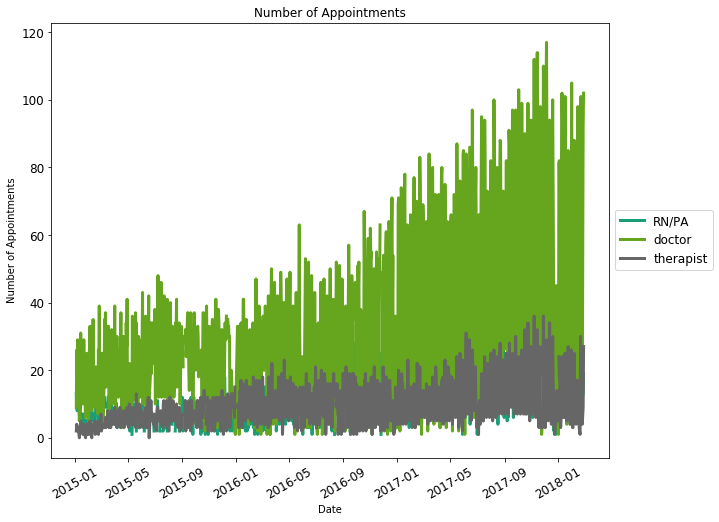

In [70]:
plot_num_appointments(df=merged2, group_col='Specialty', count_col='Provider', plot_name='Number of Appointments', colormap='Dark2')

In [71]:
merged2['DurationHours'] = merged2['AppointmentDuration'] /60

In [72]:
time_spent_by_date = merged2.groupby([merged2.index.date, 'Specialty'])['DurationHours'].sum()

In [73]:
time_spent_by_date

            Specialty
2015-01-05  RN/PA         9.750000
            doctor       13.500000
            therapist     4.500000
2015-01-06  RN/PA         6.750000
            doctor       23.000000
            therapist     7.000000
2015-01-07  RN/PA         6.000000
            doctor       17.000000
            therapist     3.000000
2015-01-08  RN/PA         6.750000
            doctor       23.750000
            therapist     9.000000
2015-01-09  doctor       12.000000
            therapist     4.000000
2015-01-12  RN/PA         9.000000
            doctor        8.500000
            therapist     3.000000
2015-01-13  RN/PA         5.250000
            doctor       20.000000
            therapist     6.000000
2015-01-14  RN/PA         6.750000
            doctor       15.750000
            therapist     3.000000
2015-01-15  RN/PA         8.250000
            doctor       26.500000
            therapist     5.000000
2015-01-16  doctor       12.750000
            therapist     2.50000

In [74]:
# merged2.groupby([merged2.index.date, 'Specialty'])['DurationHours'].sum()

In [75]:
date = pd.to_datetime(merged2.index,format='%Y-%m-%d')

In [76]:
merged2['AppointmentDate'] = date

In [77]:
def plot_time_spent(df, date_col, group_col, duration_col, plot_name, colormap='Dark2'):
    """ Plot duration data grouped by month"""
    ax = df.groupby([df.index.date, group_col])[duration_col]\
    .sum().unstack().plot(figsize=(10,8),colormap=colormap, linewidth=3, fontsize=12, rot=30)
    ax.set_title(plot_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Time')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12)
    plt.show()

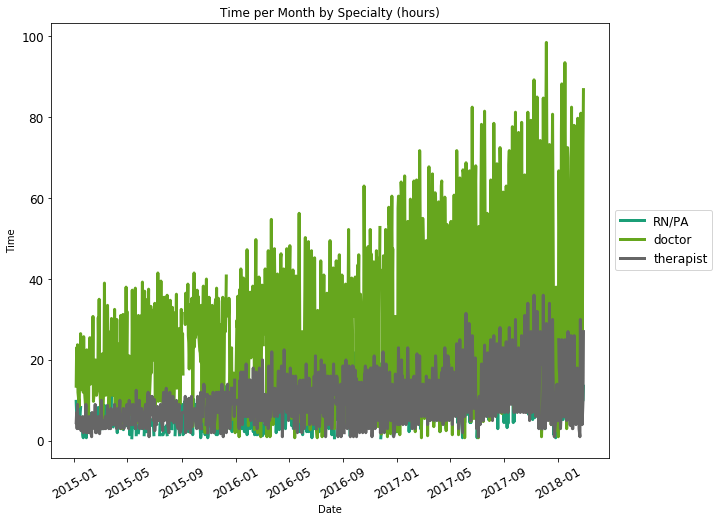

In [78]:
plot_time_spent(df=merged2, date_col='AppointmentDate', group_col='Specialty', duration_col='DurationHours',\
            plot_name='Time per Month by Specialty (hours)', colormap='Dark2')

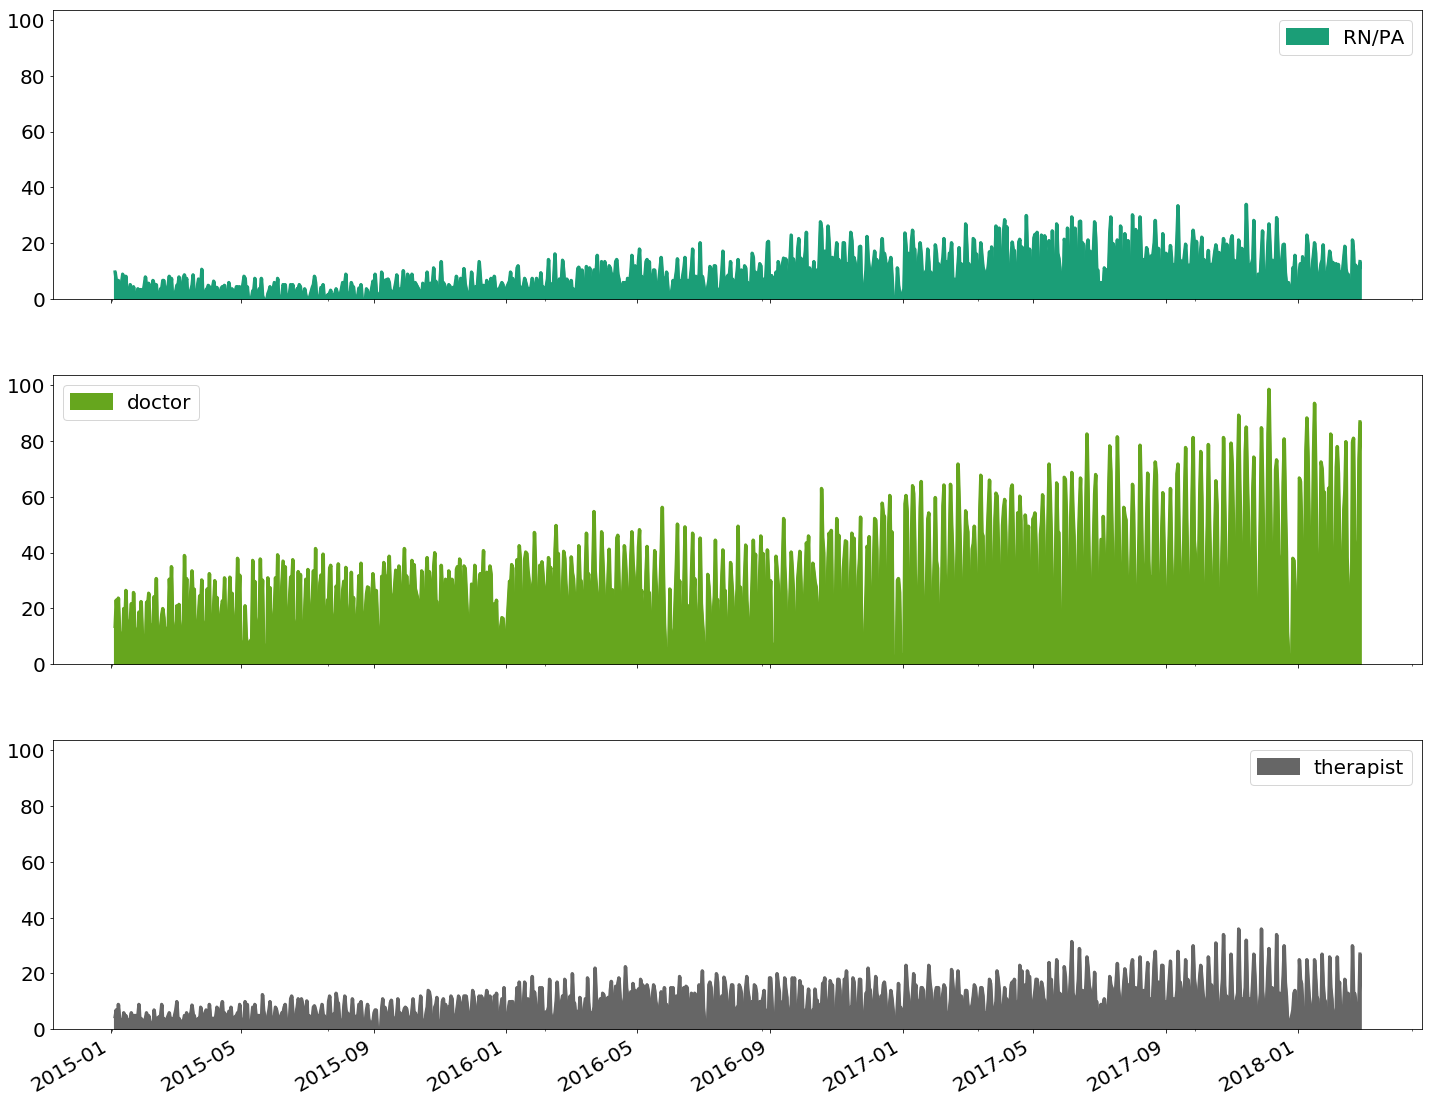

In [79]:
params = {'legend.fontsize': 20, 'legend.handlelength': 2, 'axes.labelsize': 'medium'}
plt.rcParams.update(params)
fig = merged2.groupby([merged2.index.date, 'Specialty'])['DurationHours'].sum().unstack().plot.area(subplots=True,\
    colormap='Dark2', figsize=(20,50), layout=(10,1), sharex=True, sharey=True, linewidth=3, fontsize=20)
plt.xlabel('Date')
plt.ylabel('Time (hours)', fontsize=20)
plt.tight_layout()
plt.show()

In [80]:
merged2['AppointmentDate'] = merged2.index

In [81]:
duration_df = merged2[['Provider', 'Specialty', 'AppointmentCreated', 'AppointmentDate', 'AppointmentDuration',
       'ReasonForVisitName', 'DurationHours', 'ReasonForVisitDescription','MeetingStatusName', 'MeetingStatusDescription',
       'OfficeId']]

In [82]:
duration_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54353 entries, 2018-02-27 19:00:00 to 2015-01-05 09:00:00
Data columns (total 11 columns):
Provider                     53254 non-null float64
Specialty                    54353 non-null object
AppointmentCreated           54331 non-null datetime64[ns]
AppointmentDate              54353 non-null datetime64[ns]
AppointmentDuration          54353 non-null int64
ReasonForVisitName           54353 non-null object
DurationHours                54353 non-null float64
ReasonForVisitDescription    54353 non-null object
MeetingStatusName            54353 non-null object
MeetingStatusDescription     54353 non-null object
OfficeId                     54353 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 6.2+ MB


In [83]:
duration_df.isnull().sum()

Provider                     1099
Specialty                       0
AppointmentCreated             22
AppointmentDate                 0
AppointmentDuration             0
ReasonForVisitName              0
DurationHours                   0
ReasonForVisitDescription       0
MeetingStatusName               0
MeetingStatusDescription        0
OfficeId                        0
dtype: int64

In [84]:
# drop appointments that are longer than 90 minutes
duration_df = duration_df[duration_df['AppointmentDuration'] <= 90]

In [85]:
# drop remaining columns with missing values
duration_df.dropna(axis=0, inplace=True)

#### get appointment time by week for data through February

In [86]:
doctors = duration_df[duration_df['Specialty'] == 'doctor']
therapists = duration_df[duration_df['Specialty'] == 'therapist']
RN_PA = duration_df[duration_df['Specialty'] == 'RN/PA']

In [87]:
doc_duration = doctors.groupby(doctors.index.date)['DurationHours'].sum()
RN_PA_duration = RN_PA.groupby(RN_PA.index.date)['DurationHours'].sum()
therapist_duration = therapists.groupby(therapists.index.date)['DurationHours'].sum()

In [88]:
index_to_datetime(doc_duration)
index_to_datetime(RN_PA_duration)
index_to_datetime(therapist_duration)

In [89]:
# resample to weekly data
doc_duration = doc_duration.resample('W-MON').sum()
RN_PA_duration = RN_PA_duration.resample('W-MON').sum()
therapist_duration = therapist_duration.resample('W-MON').sum()

In [90]:
# remove first row --> partial week
# cut off last row --> March 5th for all categories that was introduced during resampling b/c it represents
# a partial week's data
doc_duration = doc_duration[1:-1]
RN_PA_duration = RN_PA_duration[1:-1]
therapist_duration = therapist_duration[1:-1]

In [91]:
def plot_series(series, xlabel, ylabel, plot_name):
    "Plots simple time series from Pandas Series"
    ax = series.plot(figsize=(8,3), linewidth = 3, fontsize=10, grid=True, rot=30)
    ax.set_title(plot_name, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.show()

In [92]:
doc_duration.tail()

2018-01-29    283.583333
2018-02-05    280.750000
2018-02-12    281.500000
2018-02-19    224.750000
2018-02-26    314.000000
Freq: W-MON, Name: DurationHours, dtype: float64

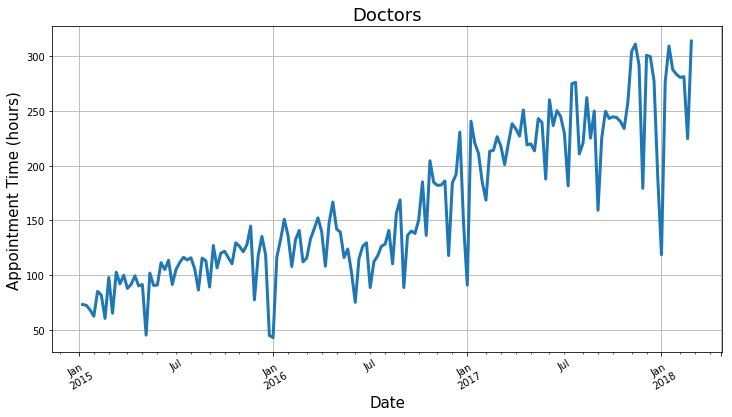

In [93]:
# Plot time series doctors
plot_series_save_fig(series=doc_duration, figsize=(12,6), xlabel='Date', ylabel='Appointment Time (hours)',\
                     plot_name='Doctors', figname='./images/doctors_weekly_time_series.png')

In [94]:
def plot_series_and_differences(series, ax, num_diff, title):
    "Plot raw data and specified number of differences"
    ax[0].plot(series.index, series)
    ax[0].set_title('Raw series: {}'.format(title))
    for i in range(1, num_diff+1):
        diff = series.diff(i)
        ax[i].plot(series.index, diff)
        ax[i].set_title('Difference # {}'.format(str(i)))   

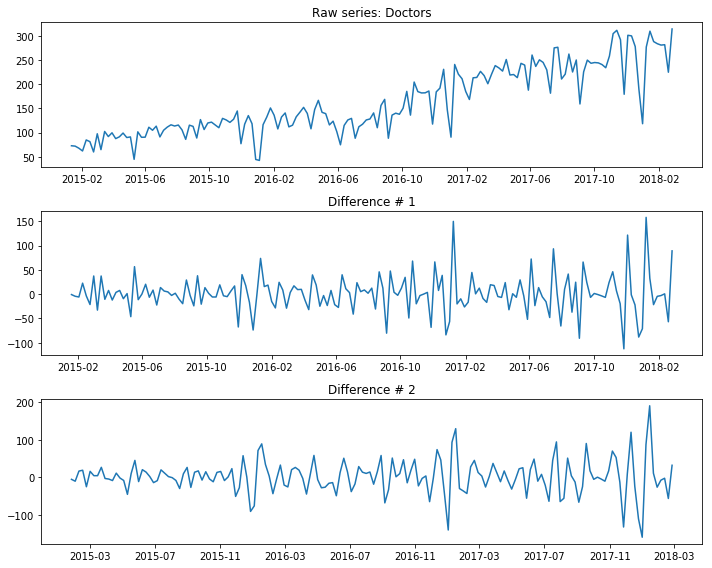

In [95]:
fig, axes = plt.subplots(3, figsize=(10, 8))
plot_series_and_differences(series=doc_duration, ax=axes, num_diff=2, title='Doctors')
fig.tight_layout()

In [96]:
def run_augmented_Dickey_Fuller_test(series, num_diffs=None):
    test = sm.tsa.stattools.adfuller(series)
    if test[1] >= 0.05:
        print('The p-value for the series is: {p}, which is not significant'.format(p=test[1]))
    else:
        print('The p-value for the series is: {p}, which is significant'.format(p=test[1]))  
    if num_diffs:
        for i in range(1, num_diffs +1):
            test = sm.tsa.stattools.adfuller(series.diff(i)[i:])
            if test[1] >= 0.05:
                print('The p-value for difference {diff} is: {p}, which is not significant'.format(diff=str(i), p=test[1]))
            else:
                print('The p-value for difference {diff} is: {p}, which is significant'.format(diff=str(i), p=test[1]))   

In [97]:
# test for stationarity of doctors data, 1st and 2nd diff
run_augmented_Dickey_Fuller_test(doc_duration, num_diffs=2)

The p-value for the series is: 0.8749925648580719, which is not significant
The p-value for difference 1 is: 4.82609162958424e-24, which is significant
The p-value for difference 2 is: 2.3949700789661748e-05, which is significant


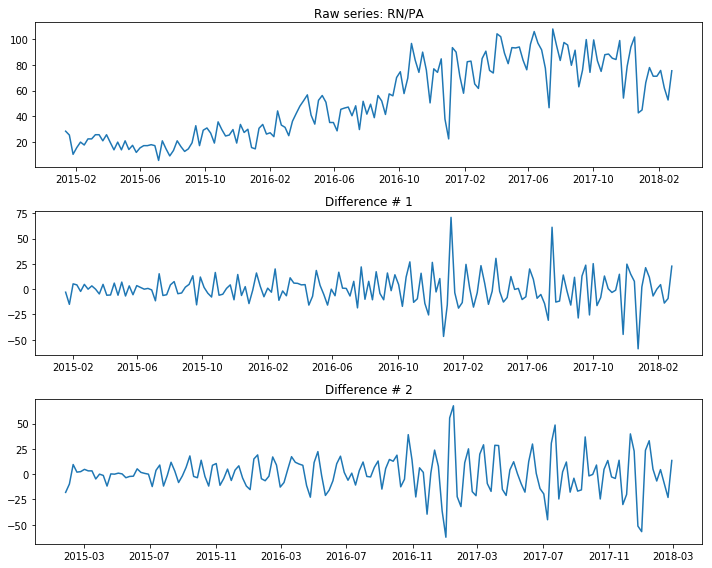

In [98]:
fig, axes = plt.subplots(3, figsize=(10, 8))
plot_series_and_differences(series=RN_PA_duration, ax=axes, num_diff=2, title='RN/PA')
fig.tight_layout()

In [99]:
# test for stationarity of RN/PA data, 1st and 2nd diff
run_augmented_Dickey_Fuller_test(RN_PA_duration, num_diffs=2)

The p-value for the series is: 0.745308355716746, which is not significant
The p-value for difference 1 is: 1.9074256437266655e-05, which is significant
The p-value for difference 2 is: 0.003569248965384147, which is significant


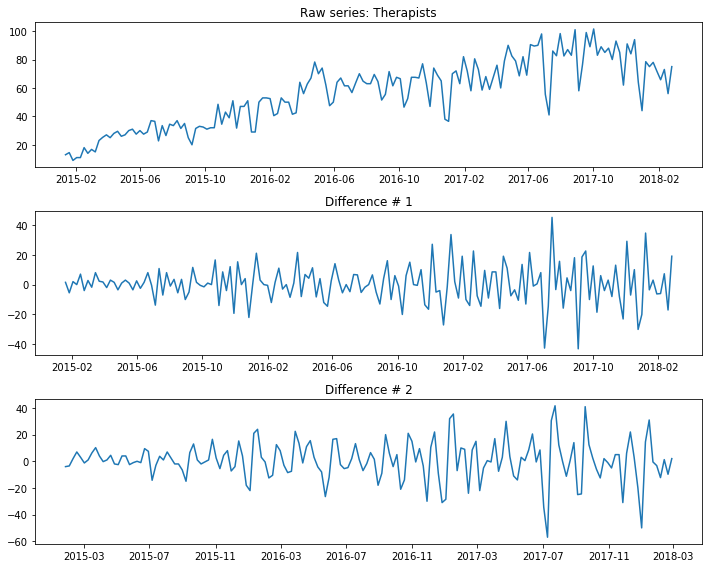

In [100]:
fig, axes = plt.subplots(3, figsize=(10, 8))
plot_series_and_differences(series=therapist_duration, ax=axes, num_diff=2, title='Therapists')
fig.tight_layout()

In [101]:
# test for stationarity of therapist data, 1st and 2nd diff
run_augmented_Dickey_Fuller_test(therapist_duration, num_diffs=2)

The p-value for the series is: 0.21276779236785742, which is not significant
The p-value for difference 1 is: 1.054898208902889e-10, which is significant
The p-value for difference 2 is: 6.624578696185626e-05, which is significant


#### plot detrended series

In [102]:
## plot detrended doc_dur using functions from matt drury tine series lecture w/ some 
# modifications
def make_col_vector(array):
    """Convert a one dimensional numpy array to a column vector."""
    return array.reshape(-1, 1)

def make_design_matrix(array):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(make_col_vector(array), prepend=False)

In [103]:
def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

In [104]:
def plot_trend_data(ax, series):
    ax.plot(series.index, series)

def plot_linear_trend(ax, series, title='', xlabel='', ylabel=''):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, series)
    ax.plot(series.index, linear_trend)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

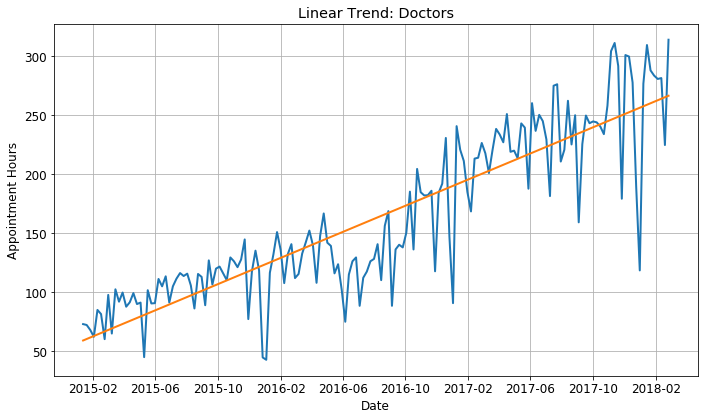

In [105]:
# plot linear model for doctors data
params = {'figure.figsize': [8,8],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)
fig, ax = plt.subplots(1, figsize=(10,6))
plot_linear_trend(ax, title='Linear Trend: Doctors', series=doc_duration, xlabel='Date',\
                  ylabel='Appointment Hours')
plt.tight_layout()
plt.savefig('./images/dr_linear_trend.png')

In [106]:
# get detrended series by subtracting the linear fit trend from original data
doctors_trend = fit_linear_trend(doc_duration)
doctors_detrended = doc_duration - doctors_trend

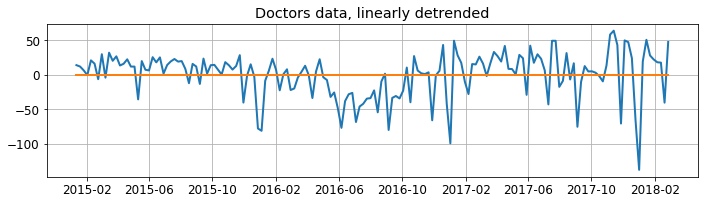

In [107]:
# plot detrended data
fig, ax = plt.subplots(1, figsize=(10,3))
plot_linear_trend(ax, title='Doctors', series= doctors_detrended)
plt.title('Doctors data, linearly detrended')
plt.tight_layout()

In [108]:
# Calculate and plot moving average
def fit_moving_average_trend(series, window=14):
    return series.rolling(window, center=True).mean()

def plot_with_moving_average(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, series)
    ax.plot(series.index, moving_average_trend)
    ax.set_title('{title}, window={w}'.format(title=name, w=str(window)))

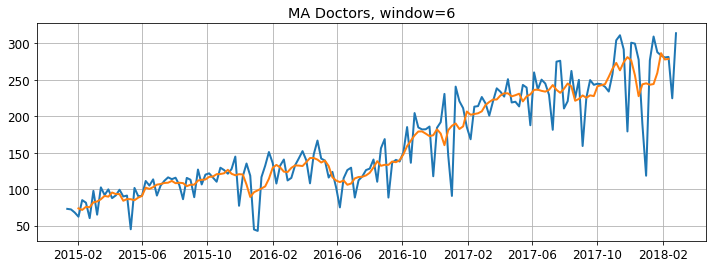

In [109]:
fig, ax = plt.subplots(1, figsize=(12,4))
plot_with_moving_average(ax, 'MA Doctors', doc_duration)
fig.savefig('./images/dr_MA6.png')

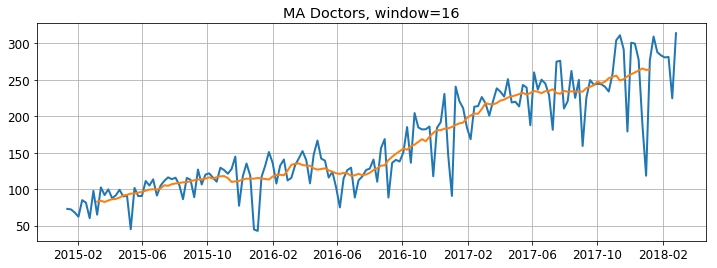

In [110]:
fig, ax = plt.subplots(1, figsize=(12,4))
plot_with_moving_average(ax, 'MA Doctors', doc_duration, window=16)
fig.savefig('./images/dr_MA16.png')

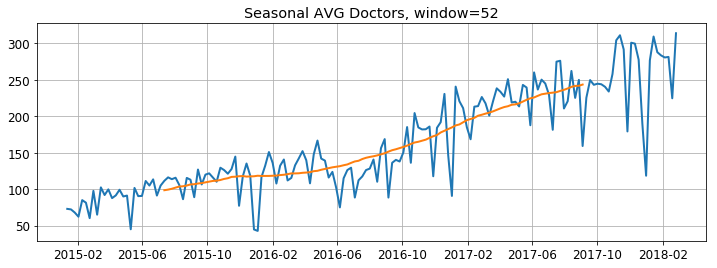

In [111]:
# look for seasonal patterns using window=52
fig, ax = plt.subplots(1, figsize=(12,4))
plot_with_moving_average(ax, 'Seasonal AVG Doctors', doc_duration, window=52)

In [112]:
def plot_autocorrelation(series, params, lags, alpha, title):
    plt.rcParams.update(params)
    acf_plot = tsaplots.plot_acf(series, lags=lags, alpha=alpha)
    plt.title(title)
    plt.xlabel('Number of Lags')
    plt.show()

def plot_partial_autocorrelation(series, params, lags, alpha, title):
    plt.rcParams.update(params)
    acf_plot = tsaplots.plot_pacf(series, lags=lags, alpha=alpha)
    plt.xlabel('Number of Lags')
    plt.title(title)
    plt.show()

#### plot decomposition for each specialty

In [113]:
def plot_decomposition(series, params, freq, title):
    "Plots observed, trend, seasonal, residual"
    plt.rcParams.update(params)
    decomp = sm.tsa.seasonal_decompose(series, freq=freq)
    fig = decomp.plot()
    plt.title(title)
    plt.show()

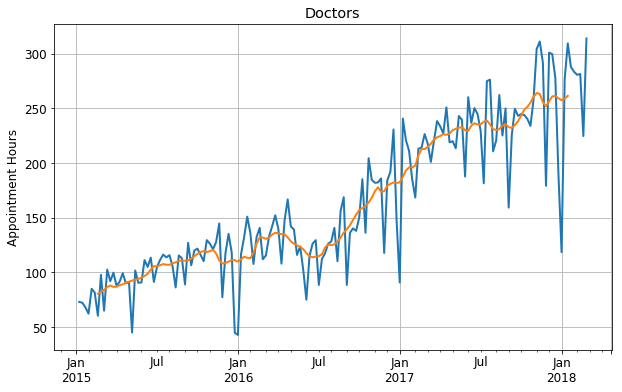

In [114]:
params = {'figure.figsize': [10,6],'axes.grid.axis': 'both', 'axes.grid': True,'axes.labelsize': 'Medium', 'font.size': 12.0, 'lines.linewidth': 2}

dr_decomp = sm.tsa.seasonal_decompose(doc_duration, freq=12)
plt.rcParams.update(params)
fig = dr_decomp.observed.plot()
fig = dr_decomp.trend.plot()
plt.title('Doctors')
plt.ylabel('Appointment Hours')
plt.savefig('./images/doctors_hours_with_trend.png')
plt.show()

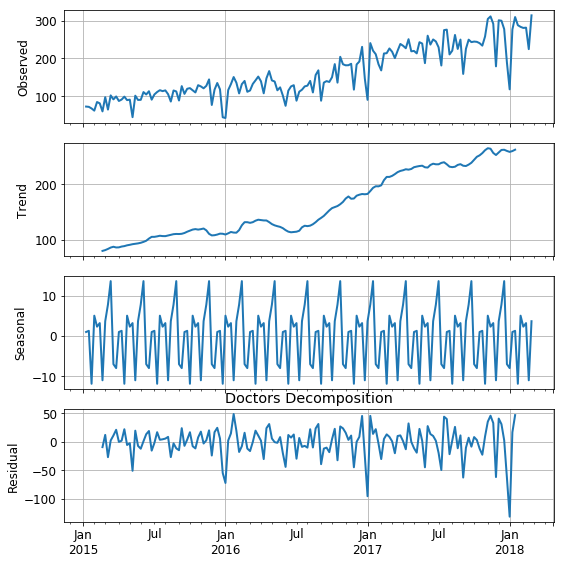

In [115]:
# Doctors Decomposition
params = {'figure.figsize': [8, 8],'axes.grid.axis': 'both', 'axes.grid': True,'axes.labelsize': 'Medium', 'font.size': 12.0, 'lines.linewidth': 2}
plot_decomposition(doc_duration, params=params, freq=12, title='Doctors Decomposition')

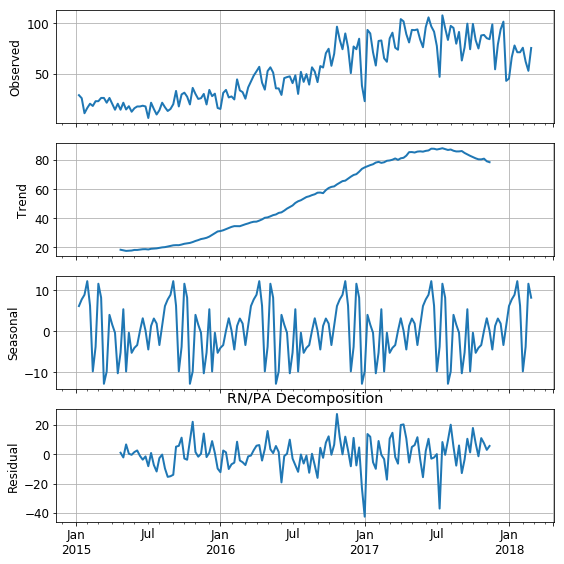

In [116]:
# RN/PA decomposition
params = {'figure.figsize': [8, 8],'axes.grid.axis': 'both', 'axes.grid': True,'axes.labelsize': 'Medium', 'font.size': 12.0, 'lines.linewidth': 2}
plot_decomposition(RN_PA_duration, params=params, freq=31, title='RN/PA Decomposition')

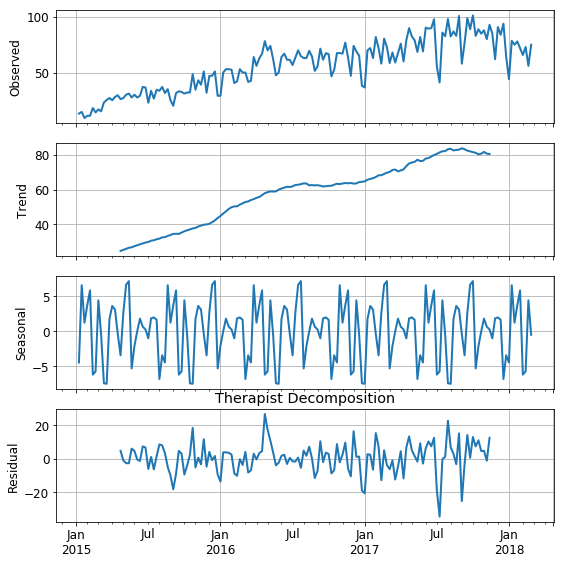

In [117]:
# Therapists decomposition
params = {'figure.figsize': [8, 8],'axes.grid.axis': 'both', 'axes.grid': True,'axes.labelsize': 'Medium', 'font.size': 12.0, 'lines.linewidth': 2}
plot_decomposition(therapist_duration, params=params, freq=31, title='Therapist Decomposition')